# Weighted distances for multiple variables

$$D(x,y) = \sqrt{(x-y)^T\cdot A\cdot(x-y)}$$

- $A$ is a diagonal matrix

## Library and dataset import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

%config Completer.use_jedi = False
session = tf.Session()

Create url and import the data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_file = requests.get(url)

Feature selection using header values

In [3]:
housing_header = ['CRIM', #      per capita crime rate by town
                 'ZN', #        proportion of residential land zoned for lots over 25,000 sq.ft.
                 'INDUS', #     proportion of non-retail business acres per town
                 'CHAS', #      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
                 'NOX', #       nitric oxides concentration (parts per 10 million)
                 'R', #        average number of rooms per dwelling
                 'AGE', #       proportion of owner-occupied units built prior to 1940
                 'DIS', #       weighted distances to five Boston employment centres
                 'RAD', #       index of accessibility to radial highways
                 'TAX', #      full-value property-tax rate per $10,000
                 'PTRATIO', #  pupil-teacher ratio by town
                 'B', #        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
                 'LSTAT', #    % lower status of the population
                 'MEDV'] #     Median value of owner-occupied homes in $1000's 
cols_used = ["CRIM", "INDUS", "NOX", "R", "AGE", "DIS", "TAX", "PTRATIO", "B", "LSTAT"]
num_features = len(cols_used)

## Data selection and test/training dataset split

First clean the raw data. X and Y values assignment

In [4]:
housing_data =[[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

Normalize between 0 and 1 the X values

In [5]:
x_vals = (x_vals - x_vals.min(0))/x_vals.ptp(0)

Train and test data split

In [6]:
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))
x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]

y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

Calculate the standard deviation of each feature

In [7]:
weight_diag = x_vals.std(0)

# KNN algorithm

Hyperparameter definition

In [8]:
k = 4  #Hyperparameter (apriori selected)
batch_size = len(x_vals_test)

### TensorFlow variable creation

General variables

In [9]:
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)

y_target_train = tf.placeholder(shape = [None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

Diagonal weighted matrix using features std

In [10]:
weight_matrix = tf.cast(tf.diag(weight_diag), dtype = tf.float32)

Distance using the weighted matrix and the beggining formula

In [11]:
subs_term = tf.subtract(x_data_train, tf.expand_dims(x_data_test, 1))
first_prod = tf.matmul(subs_term, tf.tile(tf.expand_dims(weight_matrix, 0), [batch_size, 1, 1]))
second_prod = tf.matmul(first_prod, tf.transpose(subs_term, perm = [0,2,1]))

distance = tf.sqrt(tf.matrix_diag_part(second_prod))

The k max values along the distance tensor:

In [12]:
top_k_xvals, top_k_idx = tf.nn.top_k(tf.negative(distance), k = k)

Weighted average

In [13]:
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
x_sums_rep = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
x_vals_w = tf.expand_dims(tf.divide(top_k_xvals, x_sums_rep),1) # -> wi = di / \sum(dj)

Prediction:

In [14]:
top_k_yvals = tf.gather(y_target_train, top_k_idx)
prediction = tf.squeeze(tf.matmul(x_vals_w, top_k_yvals),axis=[1]) ## \sum w_i y_i

Error metric Mean squared error:

In [15]:
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Variable initialization:

In [16]:
init = tf.global_variables_initializer()
session.run(init)

### Model prediction

In [17]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_idx = i*batch_size
    max_idx = min((i+1)*batch_size, len(x_vals_train))
    x_batch = x_vals_test[min_idx:max_idx]
    y_batch = y_vals_test[min_idx:max_idx]
        
    predictions = session.run(prediction, feed_dict={x_data_train: x_vals_train,
                                                     x_data_test: x_batch,
                                                     y_target_train: y_vals_train,
                                                     y_target_test: y_batch})
    
    batch_mse = session.run(mse, feed_dict = {x_data_train: x_vals_train,
                                              x_data_test: x_batch,
                                              y_target_train: y_vals_train,
                                              y_target_test: y_batch})
    print('MSE = '+str(np.round(batch_mse,3)))

MSE = 11.564


## Data Visualization

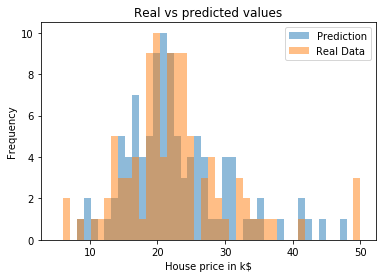

In [18]:
bins = np.linspace(5, 50, 45)
plt.hist(predictions, bins, alpha = 0.5, label = 'Prediction')
plt.hist(y_batch, bins, alpha = 0.5, label = 'Real Data')
plt.title('Real vs predicted values')
plt.xlabel('House price in k$')
plt.ylabel('Frequency')
plt.legend(loc = 'upper right')
plt.show()

### Hyperparameter optimization

Function to run multiple K values:

In [19]:
def knn(k):
    batch_size = len(x_vals_test)
    
    top_k_xvals, top_k_idx = tf.nn.top_k(tf.negative(distance), k = k)
    x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
    x_sums_rep = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
    x_vals_w = tf.expand_dims(tf.divide(top_k_xvals, x_sums_rep),1) # -> wi = di / \sum(dj)
    top_k_yvals = tf.gather(y_target_train, top_k_idx)
    prediction = tf.squeeze(tf.matmul(x_vals_w, top_k_yvals),axis=[1]) ## \sum w_i y_i
    mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)
    
    min_idx = i*batch_size
    max_idx = min((i+1)*batch_size, len(x_vals_train))
    x_batch = x_vals_test[min_idx:max_idx]
    y_batch = y_vals_test[min_idx:max_idx]
        
    predictions = session.run(prediction, feed_dict={x_data_train: x_vals_train,
                                                     x_data_test: x_batch,
                                                     y_target_train: y_vals_train,
                                                     y_target_test: y_batch})
    
    batch_mse = session.run(mse, feed_dict = {x_data_train: x_vals_train,
                                              x_data_test: x_batch,
                                              y_target_train: y_vals_train,
                                              y_target_test: y_batch})
    
    return batch_mse

Then run the function to see the results:

K value = 2, MSE = 18.32489
K value = 3, MSE = 12.14937
K value = 4, MSE = 11.564157
K value = 5, MSE = 12.217177
K value = 6, MSE = 16.045332
K value = 7, MSE = 18.510786
K value = 8, MSE = 18.994642
K value = 9, MSE = 21.977562
K value = 10, MSE = 23.380709
K value = 11, MSE = 23.120495
K value = 12, MSE = 22.926983
K value = 13, MSE = 23.072237
K value = 14, MSE = 23.626179
K value = 15, MSE = 23.69198
K value = 16, MSE = 24.541056
K value = 17, MSE = 25.151245
K value = 18, MSE = 24.565376
K value = 19, MSE = 24.459558
K value = 20, MSE = 24.491858
K value = 21, MSE = 25.190023
K value = 22, MSE = 24.926756
K value = 23, MSE = 25.465807
K value = 24, MSE = 25.021975
K value = 25, MSE = 25.143456
K value = 26, MSE = 25.36186
K value = 27, MSE = 24.461546
K value = 28, MSE = 24.239988
K value = 29, MSE = 24.647926


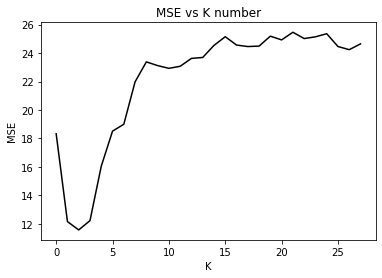

In [20]:
mse_k = []
for k in range(2, 30):
    mse_temp = knn(k)
    mse_k.append(mse_temp)
    print('K value = '+str(k)+', MSE = '+str(mse_temp))

plt.plot(mse_k, 'k-', label = 'MSE')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('MSE vs K number')
plt.show()